Build Multivariate Regression
====

The first regression we built was a univariate regression meaning we had one independant variable, which in this case was 'borrower_count'. Our EDA demonstrated that in general, the more borrowers the higher the loan amount. 

However, if we look at a scatter plot of the loan_amount vs borrower_count below, we can see that there are at least two distinct trends and the majority of multi borrower loans are with One Acre Fund. To look at these trends more closely, we can look at the same plot for all the unique top_partners

In [1]:
# Load python packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns

# packages for checking assumptions
from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
import statsmodels.formula.api as sm

In [2]:
# Code from previous notebook
# Load Data
data_path = '../data/'
df = pd.read_csv(data_path+'df_abridged.csv', low_memory=False)
# Define our dependant variable
y = df['loan_amount']
# Define  our independant variables
X = df[['borrower_count']]
# Add an intercept term to the independant variables. This is needed in order to include the constant term from
# linear regression equation.
X['cnst'] = 1
# Split our data into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model0 = sm.OLS(endog = y_train,exog = X_train).fit()
print(model0.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                 1.432e+04
Date:                Wed, 13 Dec 2017   Prob (F-statistic):               0.00
Time:                        18:56:02   Log-Likelihood:            -6.9885e+05
No. Observations:               94559   AIC:                         1.398e+06
Df Residuals:                   94557   BIC:                         1.398e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
borrower_count    50.4097      0.421    119.

/Users/brian/anaconda3/envs/good/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [3]:
# TODO: Replace wit Seaborn 
# ggplot(df, aes(x='borrower_count', y='loan_amount',color='top_partners')) + geom_point()

In [4]:
# TODO: Replace wit Seaborn 
# for partner in df['top_partners'].unique():
#     ggplot(df[df['top_partners']==partner], aes(x='borrower_count', y='loan_amount',color='sector')) + geom_point() + ggtitle(partner)

A stronng linear relationship between borrower_count and loan_amount only exists for the following top_partners:
- Hand in Hand Eastern Africa
- One Acre Fund

For One Acre Fund, the trend is very interesting. There are two very dictinct linear trends. Further investigation shows that this is temporal effect. One Acre Fund loans between November 2013 and April 2014 were generally higher than on average:

In [5]:
# Create condition statements to filter for One Acre Fund loan during the periods of interest
condition_high = (df['top_partners']=='One Acre Fund')&(((df.posted_year == 2013.0) & (df.posted_month > 10))|((df.posted_year ==2014.0)&(df.posted_month < 5)))
condition_low = (df['top_partners']=='One Acre Fund')&(~((df.posted_year == 2013.0) & (df.posted_month > 10)))&(~((df.posted_year ==2014.0)&(df.posted_month < 5)))

# Filter dataframe for loans of interest
df_oaf_high = df[condition_high]
df_oaf_low = df[condition_low]


In [6]:
# TODO: replace with Seaborn
# # Scatter plots of loan_amount vs borrower count
# ggplot(df_oaf_high, aes(x='borrower_count', y='loan_amount',color='posted_month')) +geom_point() + ggtitle('loan amount by borrower count for One Acre Fund during the high loan period')
# ggplot(df_oaf_low, aes(x='borrower_count', y='loan_amount',color='posted_month')) +geom_point() + ggtitle('loan amount by borrower count for One Acre Fund outside the low loan period')


To improve our model, we can include 'Interaction Terms'. These are variables which describe the interaction between two or more independant varaibles. 

In this example, we expect the increase in loan amount with number of borrowers to be different for different Partners. Therefore, we create new variables which capture this interation by creating a new borrower count feature for the different partners.

As there are only two partners which show a strong relationship between borrower_count and loan_amount, we will define 4 new variables:
- bc_partner_HIHEA = borrower count (bc) for the partner Hand in Hand Eastern Africa
- bc_partner_OAD_high = borrower count (bc) for the partner One Acre Fund during the high loan period
- bc_partner_OAD_low = borrower count (bc) for the partner One Acre Fund outside the high loan period
- bc_partner_other = borrower count (bc) for all other partners

[Here](http://www.dummies.com/programming/big-data/data-science/data-science-how-to-create-interactions-between-variables-with-python/) you can find more information on Interaction Terms in regression problems.

In [7]:
# Iteraction term for all other partners
df['bc_partner_others'] = np.where(~df['top_partners'].isin(['Hand in Hand Eastern Africa','One Acre Fund']),df['borrower_count'],0)
# Iteraction term for Hand in Hand Eastern Africa
df['bc_partner_HIHEA'] = np.where(df['top_partners'] == 'Hand in Hand Eastern Africa',df['borrower_count'],0)

In [8]:
# Iteraction term for One Acre Fund in high loan period
df['bc_partner_OAF_high'] = np.where(condition_high,df['borrower_count'],0)
# Iteraction term for One Acre Fund outside of high loan period
df['bc_partner_OAF_low'] = np.where(condition_low, df['borrower_count'],0)

Now we have split out borrower_count into 4 seperate variables, lets see how the linear regression performs now.

In [9]:
# Define the dependant variable
y = df['loan_amount']
# Define the independant variables
X = df[['bc_partner_others','bc_partner_HIHEA','bc_partner_OAF_high','bc_partner_OAF_low']]
# Add an intercept term to the independant variables
X['cnst'] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/brian/anaconda3/envs/good/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
model1 = sm.OLS(endog = y_train,exog = X_train).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                 2.257e+04
Date:                Wed, 13 Dec 2017   Prob (F-statistic):               0.00
Time:                        18:56:05   Log-Likelihood:            -6.7382e+05
No. Observations:               94559   AIC:                         1.348e+06
Df Residuals:                   94554   BIC:                         1.348e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
bc_partner_others     261.7128    

Look at that! Just by creating interaction terms between the borrower_count and top_partners features, we have managed to increase our adj R2 from 0.132 up to 0.488 - Not bad! 

Also looking at the P-values tells us that all of the cooefficients are significant. The next question to ask is then, how do we interpret the coefficients of these interaction terms? Lets take the coefficient for bc_partners_HIHEA for example. We interpret this is the following way; if the top partner is Hand in Hand Eastern Africa, then for every additional borrower, we expect the loan amount to increase by $104. The same concept can be applied to the other coefficients. 


Now can we add any more features to this model? Let's think back to the EDA and feature engineering to find some other features that might be useful. Here are a few we are going to include:
- Gender
- tag_#Repeated Borrower
- sectors
- partner_delinquency_rate
- partner_loans_posted

In [11]:
# Create dummy variable for Gender
df['female'] = np.where(df['gender'] =='Female', 1, 0)
# Create dummy variable for partner_status
for status in ['active','closed']:
    df['partner_'+status] = np.where(df.partner_status ==status, 1, 0)

In [12]:
df.groupby('sector')['loan_amount'].mean().sort_values().plot(kind='bar');

Health, Wholesale, Agriculture, Arts, Food and Personal Use seem to have loan amounts different to the other sectors. Lets try including these as features...

In [13]:
for sect in ['Personal Use','Food','Arts','Agriculture','Wholesale','Health']:
    df['sector_'+sect] = np.where(df.sector ==sect, 1, 0)

In [14]:
y = df['loan_amount']
X = df[['bc_partner_others','bc_partner_HIHEA','bc_partner_OAF_high','bc_partner_OAF_low','female',
        'tag_#Repeat Borrower','sector_Personal Use','sector_Health','sector_Wholesale','sector_Agriculture',
       'kids','partner_delinquency_rate','married']]
# Add an intercept term to the independant variables
X['cnst'] = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/brian/anaconda3/envs/good/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
model2 = sm.OLS(endog = y_train,exog = X_train).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     7948.
Date:                Wed, 13 Dec 2017   Prob (F-statistic):               0.00
Time:                        18:56:13   Log-Likelihood:            -6.7060e+05
No. Observations:               94559   AIC:                         1.341e+06
Df Residuals:                   94545   BIC:                         1.341e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
bc_partner_others       

Adding these features have improved the model slightly, the adj R2 has increased from 0.488 to 0.522 and again, all the p-values are less than 0.005 so we can consider than as significant. Lets interpret the results then...
- female coef = -53. In general women ask for loans that are 64 dollars less than the equivalent asked by a man. 
- tag_#Repeat Borrower coef = 103. In general, repeat borrowers ask for 124 dollars more than none repeat borrowers. 
- sectors_Personal Use coef = -243. In general, if a loan is for personal use, it is 231 dollars less than others. The same concept applies to the sectors health, wholesale and agriculture and their respective coefficients.
- kids coef = -22. If kids is mentioned in the description, they ask for 12 dollars less.
- etc etc


** Now lets check some of the linear regression assumption that we covered above to check that we can confidently interpret the models coefficients as above **

To do this quickly, we will use the statistics given in the summary table. For more information on these, check out this [awesome page!](http://connor-johnson.com/2014/02/18/linear-regression-with-python/)

1) Normality: The Prob(JB) number is less than 0.05 which means we reject the Null Hypothesis that the data is normally distributed. **ASSUMPTION NOT MET**

2) Multiconlinearity: The Condition number is greater than 30 which means we have an issue with multicolinearity in the model. **ASSUMPTION NOT MET**

3) Autocorrelation: Durbin-Watson number is approximately 2 so no autocorrelation. **ASSUMPTION MET**

4) Homoscedasticity: Prob(Omnibus) number is less than 0.05 which means we reject the Null Hypothesis that the residuals are normally distributed. **ASSUMPTION NOT MET**

We clearly have an issue here! Although the predictive power of the model is still valid, meaning we can still predict using the model with an R^2 of 0.522 - we CANNOT interpret the coefficients in the way we would hope. 

The underlying issue here is that data is not normally distributed and that the is not always a linear relationship between the dependant and independant variables. Therefore, we may have to look towards non-parametric models.

-----

Model Evaluation
=====

Discarding the fact that our lienar regression assumptions are not met for a moment, lets evaluate how the models predictive power. 

For this purpose, we are going to switch over to sklearn's Linear Regression package. This allows us to use other sklearn metrics and functions to evaluate the model performance. An important function we are going to use here is sklearn's [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

This model allows us to perform cross validation on our training dataset and output the score of our choice. Lets walk through this now....



In [4]:
# Initialize the model. We set fit_intercept as false as we already have the constant included in our data. 
linear = LinearRegression(fit_intercept=False)
# Use the cross_val_sore function to calculate the r2 cross validation
r2_cross_val_score = cross_val_score(linear, X_train, y_train, cv = 5).mean()
# Results!
print('cross validation R2: {}'.format(r2_cross_val_score))

cross validation R2: 0.13151055727894417


The cross validation R2 score is very similar to the training R2 which gives us confidence that the model will perform well on the unseen test data!

Another useful metric to evaluate a models performance is the mean squared error which tells us how much error our model produced on average. We can also implement this in sklearn cross_val_score! By default, the cross_val_score function will use the default scorer for the model, which in the case for linear regression is the R2. 

However, we can 'create' an MSE scorer as follows and use that instead...

In [5]:
# make MSE scorer
mse_scorer = make_scorer(mean_squared_error)
# use the cross_val_score function to calculate to the cross validated MSE
mse_cross_val_score = cross_val_score(linear, X_train, y_train, scoring=mse_scorer, cv =5).mean()
# Results!
print(f'cross validation MSE: {mse_cross_val_score:.6}')
print(f'cross validation RMSE: {np.sqrt(mse_cross_val_score):.4}')

cross validation MSE: 1.53788e+05
cross validation RMSE: 392.2


This suggest that the average error in our model is 291 dollars - not bad!

** Now lets see how it performs on our test data!**

In [6]:
#Train the Model
model2 = linear.fit(X_train, y_train)
#Get R2 for test data
print(f'R2 on test data: {model2.score(X_test, y_test):.4}')

R2 on test data: 0.1369


Great! This is comparable to the cross validation R2 so we know we are not overfitting! 

In [7]:
# Get predictions for the test data
y_pred_test = model2.predict(X_test)
print(f'root mean squared error on test data: {np.sqrt(mean_squared_error(y_test,y_pred_test)):.4}')

root mean squared error on test data: 374.2


Again, this is comparable to the cross validated score so we are confident to model performs well on unseen data!

Finally, lets visualize how our model performs on the test data...

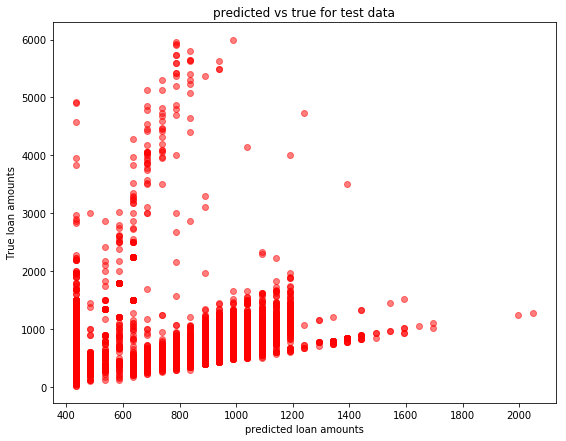

In [8]:
plt.figure(figsize=(9,7))
plt.scatter(y_pred_test, y_test, alpha=0.5, c='r')
plt.title('predicted vs true for test data')
plt.xlabel('predicted loan amounts')
plt.ylabel('True loan amounts')
plt.show();

In [9]:
df.to_csv('../data/df_end_of_linear.csv')

Next Steps
----

In the next notebook, we will go over your results and well as show you what we did for the multivariate regression. Next, we move on to a new algorithm (decision trees). Very exciting!

## Homework

Choose three other features you think might influence loan amount. Interpret the results by writing a statement like the one below that we wrote to understand the relationship with gender:

"Regardless of gender the predicted loan amount is 424 dollars. However, if the lender is a man the predicted loan amount increases by 110 dollars." 


### Univariate Regression 1

### Univariate Regression 2

### Univariate Regression 3

## Advanced Homework (Optional)

Multivariate regression is where there are multiple explanatory variables. Below is a code template for you to start playing with a multivariate model. Interpret your results.

In [ ]:
model1 = sm.ols(formula="[replace with the name of your outcome feature] ~[replace with the name of your explantory variable 1]  + [replace with the name of your explantory variable 1] +[replace with the name of your explantory variable 1] +", data=train_set)
model1_results = model1.fit()
print(model1_results.summary())

## Multivariate Regression

In [ ]:
model1 = sm.ols(formula="log_loan_amount ~ borrower_count + sector + kids + gender + widowed + pictured + video + posted_year +\
                days_to_expire + repayment_term + partner_profitability + eco_friendly + animals + elderly + technology", data=train_set)
model1_results = model1.fit()
print(model1_results.summary())

This **multi-feature** (or multivariate) model is more aligned with our understanding of the world. Most coefficients have very low p-values - a good sign! 

Our Adjusted R Squared is higher than it was in the single-feature model. Let's get into how we evaluate the model in terms of predictiveness. 

## Appendix A.
## Additional context on how to deal with skewed data:
<a id="skewed"> </a>


One potential solution is to **log transform** your data. For a quick review of logarithms, look [here](https://www.mathsisfun.com/algebra/logarithms.html). 

Note that when we log transform data, we change our interpretation of the final regression output. Previously we had a simple linear equation... 

    y = mx + b

This could be interpreted as, with every unit increase in x, we get a m increase in outcome feature y. Now we have a log equation: 

    log(y) = mx + b
    
This is less intuitive, as we have to solve for y. When we solve for y through exponentiation, we get the following equation: 

    y = 10^(mx + b)
    y = 10^(mx) * 10^(b)

The default base for log is 10. The takeaway here is that the impact x would have on y is much larger than linear - it is **exponentiated**. We will return to this interpretation in the discussion of the linear regression model. Let's try log transforming our loan_amount variable. 

In [ ]:
# Histogram of loan_amount 
plt.hist(df['loan_amount'])

In [ ]:
# Take the log of loan amount and plot histogram
log_loan_amount = np.log(df['loan_amount'])
plt.hist(log_loan_amount)

## Appendix B
### Choosing the right features

So we've increased our R2 by adding additional promising features from our Exploratory Data Analysis (EDA). However, how should we go about choosing the best combination of features for our model? In general there are two approachs:
- stepwise regression = Incrementally adding promising features and checking the R2 and p-valules at each step to check it is worth adding. This is the approach we used above. 
- Ridge or Lasso regression = These are methods whcih algorithmically reduce the beta coefficients for less important feature and can be used to find the most useful combination of features. More in depth information can be found here: [Regularization Regression](https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/)

Lets test Lasso regression and see what we get! 

For context, Ridge and Lasso regression have a hyper-parameters called 'alpha' which determines how 'strong' the regularization affect is. 

A useful way to use Ridge or Lasso regression is to run the regression over a range of alphas and see which features maintain a large beta coefficient for the longest. It is these features which have the most predictive power!

In [ ]:
# import the Ridge linear regression model from Sci-kit learn
from sklearn.linear_model import Lasso
alphas = np.arange(0.001, 0.502, 0.002)
lasso_coefs = []
X_train_lasso= X_train[['borrower_count',
                 'partner_loans_at_risk_rate','posted_year','kids','num_tags','tag_#Woman Owned Biz',
                 'tag_#Repeat Borrower','parent','married','age_int','children_int','more_one_partner_country']]
i = 0
for a in alphas:
    lassoreg = Lasso(alpha=a, copy_X=True, normalize=True)
    lassoreg.fit(X_train_lasso, y_train)
    lasso_coefs.append(lassoreg.coef_)
    i+=1

In [ ]:
lasso_coefs = np.asarray(lasso_coefs).T

plt.figure(figsize=(14,10))
for coefs, feature in zip(lasso_coefs, X_train_lasso.columns):
    plt.plot(alphas, coefs, label = feature)
plt.legend(loc='best')
plt.show()

In [ ]:
# The most important features according to Lasso Regression
lasso_coefs = []
X_train_lasso= X_train[['borrower_count',
                 'partner_loans_at_risk_rate','posted_year','num_tags',
                 'tag_#Repeat Borrower','more_one_partner_country']]
i = 0
for a in alphas:
    lassoreg = Lasso(alpha=a, copy_X=True, normalize=True)
    lassoreg.fit(X_train_lasso, y_train)
    lasso_coefs.append(lassoreg.coef_)
    i+=1
    
lasso_coefs = np.asarray(lasso_coefs).T
plt.figure(figsize=(14,10))
for coefs, feature in zip(lasso_coefs, X_train_lasso.columns):
    plt.plot(alphas, coefs, label = feature)
plt.legend(loc='best')
plt.show()

In [ ]:
X_train_3= X_train[['cnst','borrower_count','partner_loans_at_risk_rate','posted_year','num_tags',
                 'tag_#Repeat Borrower','more_one_partner_country']]

model3 = sm.OLS(endog = y_train,exog = X_train_3).fit()
print(model3.summary())

<br>
<br> 
<br>

----